In [5]:
import pickle
import numpy as np

def read_pkl(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

# Load the original data
path = r'/nas/Dataset/Phoenix/phoenix-2014-keypoints.pkl'
data = read_pkl(path)

# Choose one video (the first key) for testing
first_key = list(data.keys())[0]
print("Processing video:", first_key)

# Extract the keypoints array for the selected video
keypoints = data[first_key]['keypoints']  # shape: (n_frames, 133, 3)
print("Original keypoints shape:", keypoints.shape)

# Extract right and left hand keypoints
# Note: Python slicing is end-exclusive.
right_hand = keypoints[:, 91:112, :]   # rows 91 to 111 (21 joints)
left_hand  = keypoints[:, 112:133, :]  # rows 112 to 132 (21 joints)

# Option 1: Keep them as separate arrays (dictionary)
hands_separated = {
    'right_hand': right_hand,
    'left_hand': left_hand
}
print("Right hand shape:", right_hand.shape)
print("Left hand shape:", left_hand.shape)

# Option 2: Concatenate them along the joint axis to have a single array of shape (n_frames, 42, 3)
hands_combined = np.concatenate((right_hand, left_hand), axis=1)
print("Combined hands shape:", hands_combined.shape)


Processing video: fullFrame-210x260px/train/01April_2010_Thursday_heute_default-0/1/01April_2010_Thursday_heute
Original keypoints shape: (176, 133, 3)
Right hand shape: (176, 21, 3)
Left hand shape: (176, 21, 3)
Combined hands shape: (176, 42, 3)


In [6]:
# Create a new dictionary to store only hand keypoints for each video
data_hands = {}

for key, value in data.items():
    kp = value['keypoints']  # Original keypoints with shape (n_frames, 133, 3)
    # Extract right and left hand keypoints
    right_hand = kp[:, 91:112, :]   # rows 91 to 111
    left_hand  = kp[:, 112:133, :]  # rows 112 to 132
    # You can either store them separately or combined.
    # Here, we combine them into one array of shape (n_frames, 42, 3)
    hands = np.concatenate((right_hand, left_hand), axis=1)
    
    # Store in the new dictionary using the same key structure.
    data_hands[key] = {'keypoints': hands}

# Optionally, verify one entry
sample_key = list(data_hands.keys())[0]
print("Sample processed video keypoints shape:", data_hands[sample_key]['keypoints'].shape)

# Save the new dictionary to a pickle file
output_path = r'/nas/Dataset/Phoenix/Chingiz/phoenix-2014-hands-keypoints.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(data_hands, f)

print("Processed data saved to:", output_path)


Sample processed video keypoints shape: (176, 42, 3)
Processed data saved to: /nas/Dataset/Phoenix/Chingiz/phoenix-2014-hands-keypoints.pkl


Video fullFrame-210x260px/train/01April_2010_Thursday_heute_default-0/1/01April_2010_Thursday_heute: Visualizing joint 7


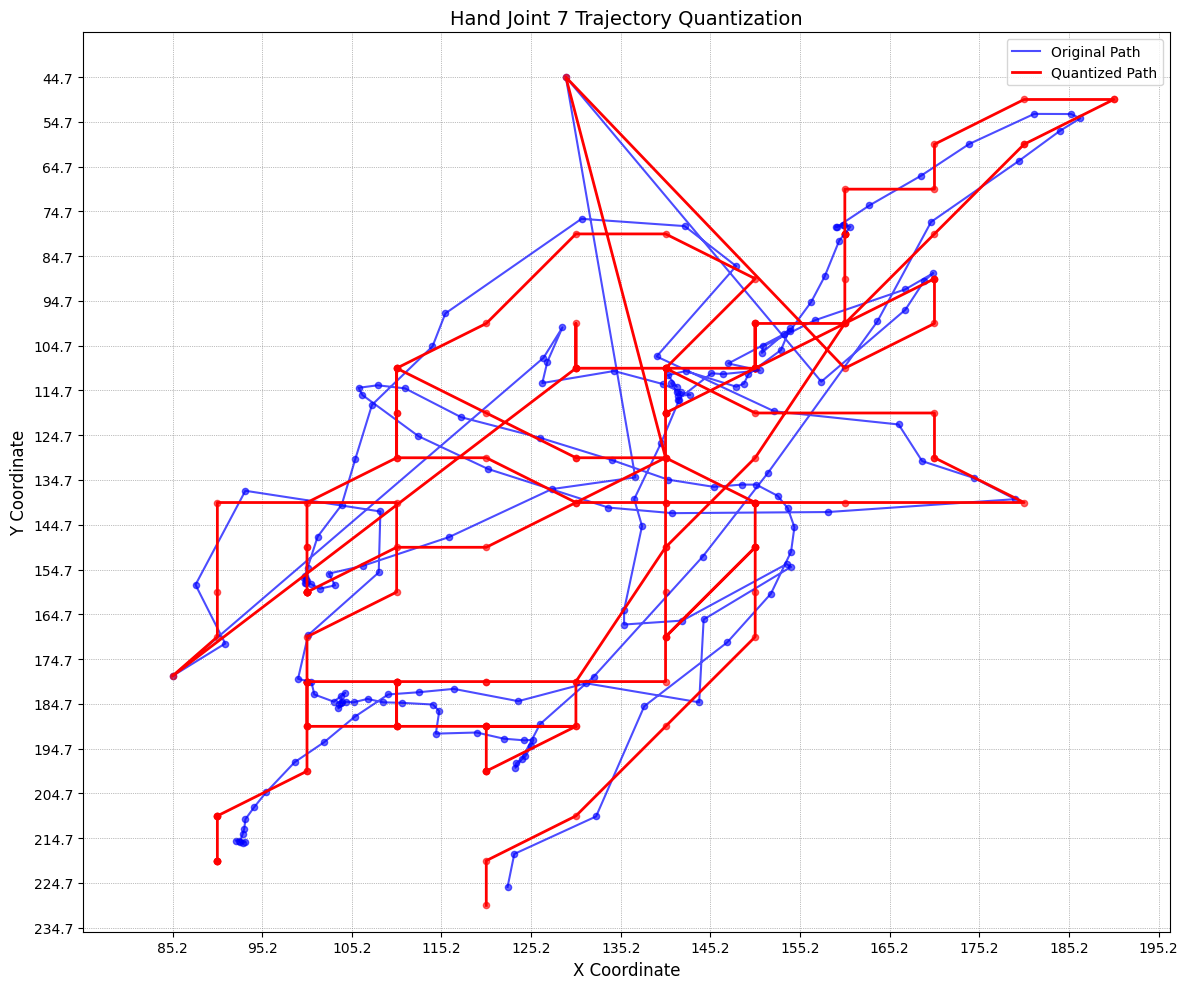

Video fullFrame-210x260px/train/01April_2010_Thursday_heute_default-2/1/01April_2010_Thursday_heute: Visualizing joint 7


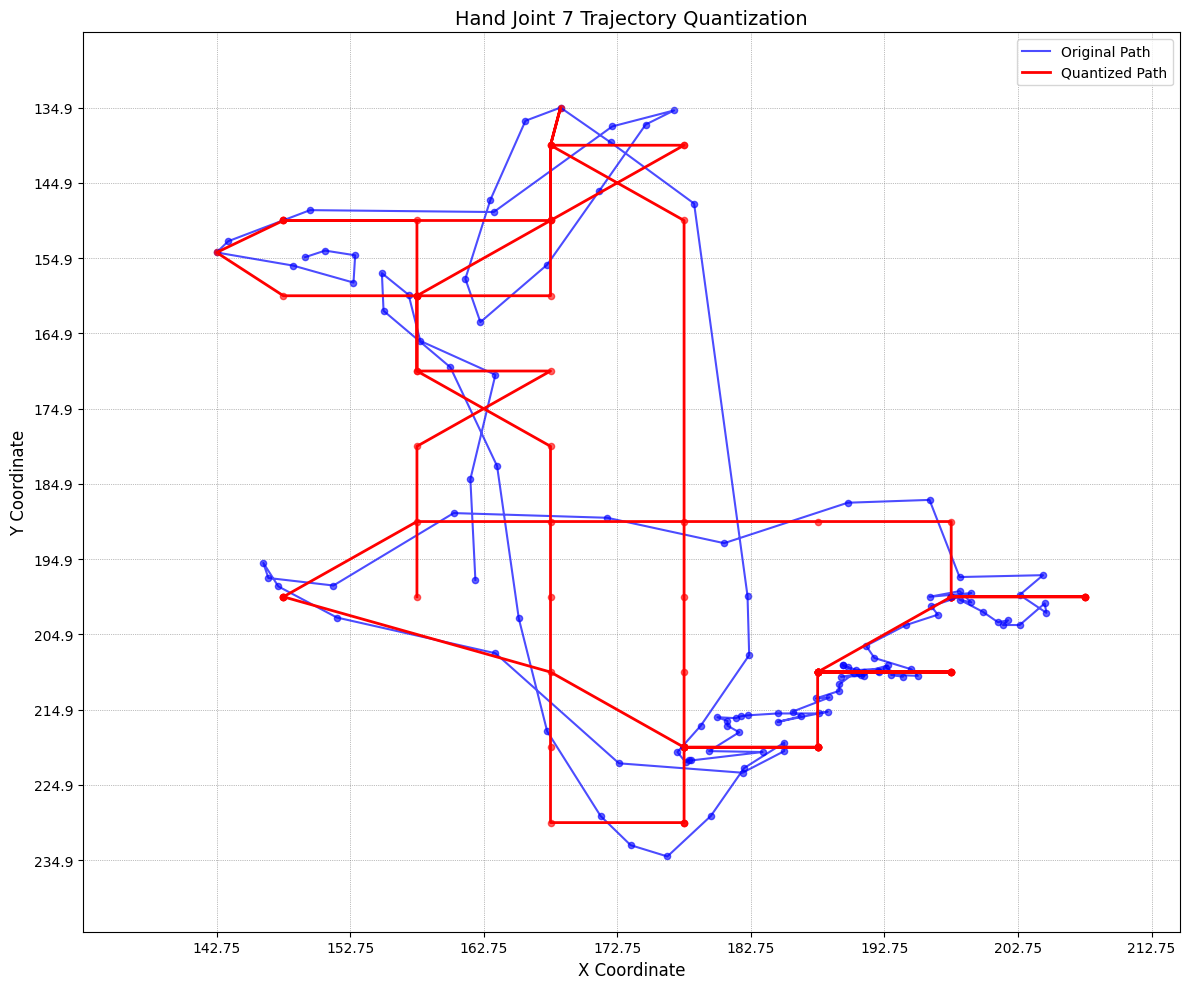

Video fullFrame-210x260px/train/01April_2010_Thursday_heute_default-3/1/01April_2010_Thursday_heute: Visualizing joint 7


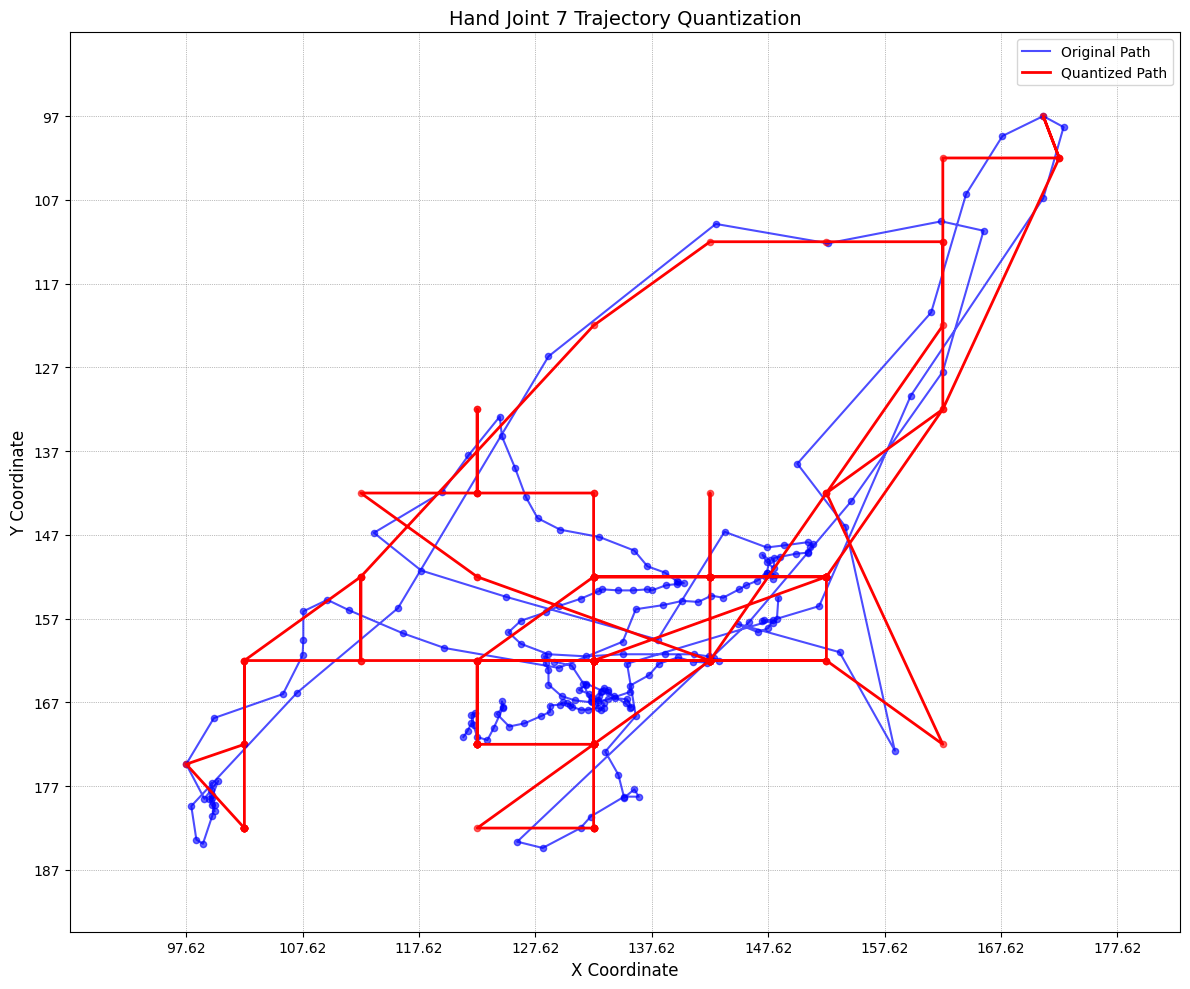

Quantized file saved to: /nas/Dataset/Phoenix/Chingiz/hoenix-2014-hands-quantized.pkl


In [8]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

def safe_grid_lines(start, stop, step, max_elements=10000):
    """
    Generate grid lines between start and stop with the given step size.
    If the number of steps would exceed max_elements, use np.linspace to create
    max_elements points between start and stop.
    """
    n = (stop - start) / step
    if n > max_elements:
        return np.linspace(start, stop, num=max_elements)
    else:
        return np.arange(start, stop, step)

def quantize_joint_trajectory(joint_points, grid_size=10, img_width=210, img_height=260):
    """
    Quantize the trajectory of a joint on a frame-by-frame basis.
    
    Before computing the grid, clip the coordinates to reasonable image bounds
    to avoid extreme ranges that may cause memory issues.
    
    Parameters:
        joint_points (np.ndarray): Array of shape (n_frames, 2) containing (x, y) coordinates.
        grid_size (float): Size of the grid cell.
        img_width (int): Maximum x value (e.g., image width; default 210).
        img_height (int): Maximum y value (e.g., image height; default 260).
        
    Returns:
        np.ndarray: Array of quantized (x, y) points with shape (n_frames, 2).
    """
    # Clip joint coordinates to the expected image dimensions.
    clipped_points = np.clip(joint_points, [0, 0], [img_width, img_height])
    
    x_min, x_max = clipped_points[:, 0].min(), clipped_points[:, 0].max()
    y_min, y_max = clipped_points[:, 1].min(), clipped_points[:, 1].max()
    
    # Calculate grid boundaries
    dis = grid_size
    x_grid_lines = safe_grid_lines(x_min - grid_size + dis, x_max + grid_size + dis, grid_size)
    y_grid_lines = safe_grid_lines(y_min - grid_size + dis, y_max + grid_size + dis, grid_size)
    
    quantized_points = []
    for x, y in clipped_points:
        # Determine which grid cell the point falls into.
        x_cell = np.searchsorted(x_grid_lines, x) - 1
        y_cell = np.searchsorted(y_grid_lines, y) - 1
        
        if 0 <= x_cell < len(x_grid_lines) and 0 <= y_cell < len(y_grid_lines):
            # Compute the center of the grid cell.
            x_center = x_grid_lines[x_cell] + grid_size / 2
            y_center = y_grid_lines[y_cell] + grid_size / 2
        else:
            # If the point falls outside the grid, use the original (clipped) point.
            x_center, y_center = x, y
        quantized_points.append((x_center, y_center))
        
    return np.array(quantized_points)

def visualize_quantization(joint_points, quantized_points, grid_size=10, joint_index=0, hand_label=""):
    """
    Visualize the original and quantized trajectories for a given joint.
    
    Parameters:
        joint_points (np.ndarray): Original (x, y) trajectory (n_frames, 2).
        quantized_points (np.ndarray): Quantized (x, y) trajectory (n_frames, 2).
        grid_size (float): The grid cell size used.
        joint_index (int): Joint index (for labeling purposes).
        hand_label (str): Label to indicate which hand or joint is visualized.
    """
    x_min, x_max = joint_points[:, 0].min(), joint_points[:, 0].max()
    y_min, y_max = joint_points[:, 1].min(), joint_points[:, 1].max()
    
    dis = grid_size
    x_grid_lines = safe_grid_lines(x_min - grid_size + dis, x_max + grid_size + dis, grid_size)
    y_grid_lines = safe_grid_lines(y_min - grid_size + dis, y_max + grid_size + dis, grid_size)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.plot(joint_points[:, 0], joint_points[:, 1], 'b-', label='Original Path', alpha=0.7)
    ax.plot(quantized_points[:, 0], quantized_points[:, 1], 'r-', label='Quantized Path', linewidth=2)
    ax.scatter(joint_points[:, 0], joint_points[:, 1], color='blue', s=20, alpha=0.6)
    ax.scatter(quantized_points[:, 0], quantized_points[:, 1], color='red', s=20, alpha=0.6)
    
    ax.set_xticks(x_grid_lines)
    ax.set_yticks(y_grid_lines)
    ax.grid(linestyle=':', linewidth=0.5, color='gray')
    ax.set_xlim(x_min - grid_size, x_max + grid_size)
    ax.set_ylim(y_min - grid_size, y_max + grid_size)
    ax.invert_yaxis()  # Invert y-axis if coordinates come from image space.
    ax.set_xlabel('X Coordinate', fontsize=12)
    ax.set_ylabel('Y Coordinate', fontsize=12)
    ax.set_title(f'{hand_label} Joint {joint_index} Trajectory Quantization', fontsize=14)
    ax.legend()
    plt.tight_layout()
    plt.show()

def process_pkl_file_quantization(input_pkl_path, output_pkl_path, grid_size=10,
                                  visualize_joint=None, max_videos_to_visualize=3,
                                  img_width=210, img_height=260):
    """
    Process a pickle file that contains hand keypoints for multiple videos and
    produce a quantized version with the same structure.
    
    The input file is assumed to be a dictionary with keys for each video. For each video,
    the value is a dictionary containing a key 'keypoints' whose value is a NumPy array of shape
    (n_frames, 42, 3). This function quantizes the (x, y) coordinates of each joint (all 42 joints)
    using a grid (with the given grid_size) while preserving the third coordinate (e.g., confidence).
    
    The output is saved as a pickle file with the same structure as the input:
      {
         video_key: {
             'keypoints': np.array( shape=(n_frames, 42, 3) )  # quantized (x, y) and original third value
         },
         ...
      }
    
    Additionally, if visualize_joint is provided (an integer in 0...41), the code will visualize
    the original and quantized trajectories for that joint in up to max_videos_to_visualize videos.
    
    Parameters:
        input_pkl_path (str): Path to the input pickle file (original hand keypoints).
        output_pkl_path (str): Path to save the quantized pickle file.
        grid_size (float): Grid cell size (e.g., 10 pixels).
        visualize_joint (int or None): If set (0–41), visualizes quantization for that joint.
        max_videos_to_visualize (int): Maximum number of videos (within this file) to show visualization.
        img_width (int): Image width to clip coordinates (default 210).
        img_height (int): Image height to clip coordinates (default 260).
    """
    with open(input_pkl_path, 'rb') as f:
        data = pickle.load(f)
    
    quantized_data = {}
    visualize_count = 0  # Counter to restrict visualization to a few videos.
    
    for video_key, value in data.items():
        kp = value['keypoints']  # Expecting shape: (n_frames, 42, 3)
        n_frames, n_joints, _ = kp.shape
        new_kp = np.empty_like(kp)
        
        for j in range(n_joints):
            # Extract (x, y) for joint j.
            joint_xy = kp[:, j, :2]
            # Quantize the (x, y) coordinates.
            q_xy = quantize_joint_trajectory(joint_xy, grid_size=grid_size,
                                             img_width=img_width, img_height=img_height)
            new_kp[:, j, :2] = q_xy
            # Preserve the third coordinate (e.g., confidence).
            new_kp[:, j, 2] = kp[:, j, 2]
        
        # Optionally visualize the quantization for a specific joint.
        if visualize_count < max_videos_to_visualize and visualize_joint is not None:
            if 0 <= visualize_joint < n_joints:
                print(f"Video {video_key}: Visualizing joint {visualize_joint}")
                visualize_quantization(
                    kp[:, visualize_joint, :2],
                    new_kp[:, visualize_joint, :2],
                    grid_size=grid_size,
                    joint_index=visualize_joint,
                    hand_label="Hand"
                )
                visualize_count += 1
        
        # Save the new quantized keypoints using the same structure.
        quantized_data[video_key] = {'keypoints': new_kp}
    
    with open(output_pkl_path, 'wb') as f:
        pickle.dump(quantized_data, f)
    
    print(f"Quantized file saved to: {output_pkl_path}")

# === Example Usage ===

input_pkl_path = r'/nas/Dataset/Phoenix/Chingiz/phoenix-2014-hands-keypoints.pkl'
output_pkl_path = r'/nas/Dataset/Phoenix/Chingiz/hoenix-2014-hands-quantized.pkl'

# For example, visualize joint index 7 (choose any index from 0 to 41)
process_pkl_file_quantization(input_pkl_path, output_pkl_path, grid_size=10,
                              visualize_joint=7, max_videos_to_visualize=3)
